In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import shap
import os
import math
import xgboost as xgb
import joblib
import warnings

plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False

In [26]:
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler 
from sklearn import preprocessing 
from sklearn.model_selection import learning_curve

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (classification_report, 
                           roc_auc_score, 
                           precision_recall_curve,
                           average_precision_score,
                           confusion_matrix,
                           f1_score,
                           roc_curve,
                           recall_score)
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.exceptions import FitFailedWarning

In [27]:
#读取数据
train_data=pd.read_csv("C:\\Users\\lenovo\\毕设-20212133050\\data_train_65.csv")
test_data=pd.read_csv("C:\\Users\\lenovo\\毕设-20212133050\\data_test_65.csv")

In [28]:
train_data.head()

,年龄,性别,GLU,CREA,DBIL,IBIL,UA,AST,ALT,UREA,TBIL,BUN/Scr,阿尔茨海默病
0,81.83,0,6.29,69.1,5.8,10.0,311.0,11.0,7.0,4.92,15.8,18.0,1
1,81.33,1,4.98,92.3,6.2,7.7,482.0,15.0,14.0,9.32,13.9,25.0,1
2,68.75,0,8.18,46.1,2.4,5.1,185.0,36.0,31.0,3.40,7.5,18.0,1
3,68.08,0,5.20,70.1,2.8,7.9,336.0,28.0,21.0,5.64,10.7,20.0,1
4,92.25,1,5.41,137.8,6.2,8.3,515.0,48.0,13.0,7.18,14.5,13.0,1


In [29]:
train_data = train_data.assign( status=train_data['阿尔茨海默病'])
test_data = test_data.assign(status=test_data['阿尔茨海默病'])

train_data = train_data.drop(['阿尔茨海默病'], axis=1)
test_data = test_data.drop(['阿尔茨海默病'], axis=1)

train_data.head()

,年龄,性别,GLU,CREA,DBIL,IBIL,UA,AST,ALT,UREA,TBIL,BUN/Scr,status
0,81.83,0,6.29,69.1,5.8,10.0,311.0,11.0,7.0,4.92,15.8,18.0,1
1,81.33,1,4.98,92.3,6.2,7.7,482.0,15.0,14.0,9.32,13.9,25.0,1
2,68.75,0,8.18,46.1,2.4,5.1,185.0,36.0,31.0,3.40,7.5,18.0,1
3,68.08,0,5.20,70.1,2.8,7.9,336.0,28.0,21.0,5.64,10.7,20.0,1
4,92.25,1,5.41,137.8,6.2,8.3,515.0,48.0,13.0,7.18,14.5,13.0,1


In [30]:
print(train_data.isnull().any())

年龄         False
性别         False
GLU        False
CREA       False
DBIL       False
IBIL       False
UA         False
AST        False
ALT        False
UREA       False
TBIL       False
BUN/Scr    False
status     False
dtype: bool


In [31]:
print(train_data.isnull().any())

年龄         False
性别         False
GLU        False
CREA       False
DBIL       False
IBIL       False
UA         False
AST        False
ALT        False
UREA       False
TBIL       False
BUN/Scr    False
status     False
dtype: bool


In [32]:
#数据分割
X_train = train_data.iloc[:,np.r_[0:12]]
y_train = train_data[['status']]
X_test = test_data.iloc[:,np.r_[0:12]]
y_test = test_data[['status']]

In [33]:
X_test

,年龄,性别,GLU,CREA,DBIL,IBIL,UA,AST,ALT,UREA,TBIL,BUN/Scr
0,84.83,0,4.33,52.4,3.8,7.2,186.0,16.0,8.0,3.92,11.0,19.0
1,74.67,1,5.97,92.3,8.0,13.4,339.0,21.0,24.0,7.32,21.4,20.0
2,79.50,1,6.08,77.4,5.7,8.9,451.0,22.0,26.0,7.71,14.6,25.0
3,81.08,1,5.05,140.1,5.0,7.6,403.0,23.0,6.0,13.42,12.6,24.0
4,85.42,0,5.21,52.5,5.2,8.8,356.0,20.0,20.0,2.30,14.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...
633,87.25,0,10.56,77.3,2.9,7.9,304.0,32.0,39.0,5.87,10.8,19.0
634,65.83,0,5.72,83.3,2.7,6.8,348.0,13.0,15.0,3.10,9.5,9.0
635,67.75,0,5.44,54.4,3.8,6.1,327.0,24.0,18.0,3.27,9.9,15.0
636,76.75,1,9.52,96.9,6.4,14.4,449.0,14.0,10.0,7.26,20.8,19.0


In [34]:
print("训练集分布:", Counter(train_data['status']))
print("测试集分布:", Counter(test_data['status']))

训练集分布: Counter({1: 2328, 0: 221})
测试集分布: Counter({1: 583, 0: 55})


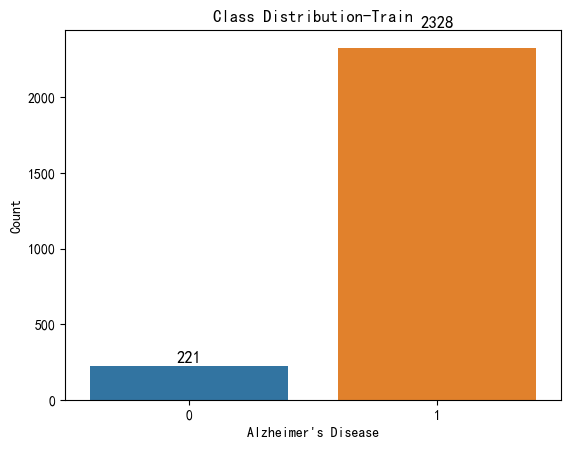

In [35]:
# 绘制条形图
ax = sns.countplot(data=train_data, x="status")
plt.xlabel("Alzheimer's Disease")
plt.ylabel("Count")
plt.title("Class Distribution-Train")

for p in ax.patches:
    height = p.get_height()
    ax.text(
        x = p.get_x() + p.get_width() / 2,  
        y = height + 0.05 * height,         
        s = f'{height:.0f}',                
        ha = 'center',                      
        va = 'bottom',                      
        fontsize=12
    )

plt.show()

In [36]:
print("训练集特征列：", X_train.columns.tolist())
print("测试集特征列：", X_test.columns.tolist())

训练集特征列： ['年龄', '性别', 'GLU', 'CREA', 'DBIL', 'IBIL', 'UA', 'AST', 'ALT', 'UREA', 'TBIL', 'BUN/Scr']
测试集特征列： ['年龄', '性别', 'GLU', 'CREA', 'DBIL', 'IBIL', 'UA', 'AST', 'ALT', 'UREA', 'TBIL', 'BUN/Scr']


In [37]:
print("X_train shape",X_train.shape)
print("y_train shape",y_train.shape)
print("X_test shape",X_test.shape)
print("y_test shape",y_test.shape)

X_train shape (2549, 12)
y_train shape (2549, 1)
X_test shape (638, 12)
y_test shape (638, 1)


In [38]:
print("原始标签分布:", train_data['status'].value_counts())

原始标签分布: 1    2328
0     221
Name: status, dtype: int64


In [39]:
# 触发此错误时，说明你的标签列只有一个类别（比如全是1或全是0）
print(y_train.value_counts())

status
1         2328
0          221
dtype: int64


In [40]:
#对数据集进行过采样
X_train = train_data.iloc[:,np.r_[0:12]]
y_train = train_data['status']
print("原始训练集类别分布:", np.bincount(y_train))

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
X_train_balanced = pd.DataFrame(X_train_balanced, columns=X_train.columns)
print("平衡后训练集类别分布:", np.bincount(y_train_balanced))

原始训练集类别分布: [ 221 2328]
平衡后训练集类别分布: [2328 2328]


In [41]:
#LR model 1
LR_model = LogisticRegression(
    class_weight='balanced', 
    max_iter=1000,  # 增加最大迭代次数以确保收敛
    random_state=42,
    solver='lbfgs'  # 使用 lbfgs 求解器
)

# 训练模型
LR_model.fit(X_train_balanced, y_train_balanced)

# 预测
LR_y_pred = LR_model.predict(X_test)
LR_y_proba = LR_model.predict_proba(X_test)[:, 1]

# 评估模型
print("\n逻辑回归 AUC-ROC:", roc_auc_score(y_test, LR_y_proba))
print("逻辑回归分类报告:\n", classification_report(y_test, LR_y_pred))


逻辑回归 AUC-ROC: 0.8531732418524872
逻辑回归分类报告:
               precision    recall  f1-score   support

           0       0.22      0.80      0.35        55
           1       0.98      0.74      0.84       583

    accuracy                           0.74       638
   macro avg       0.60      0.77      0.60       638
weighted avg       0.91      0.74      0.80       638



In [42]:
# SVM model 2
SVM_model = SVC(
    class_weight='balanced',  # 调整类别权重
    probability=True,         # 启用概率预测（用于计算AUC-ROC）
    kernel='rbf',             # 常用非线性核
    random_state=42
)
SVM_model.fit(X_train_balanced, y_train_balanced)

y_pred_SVM = SVM_model.predict(X_test)
y_proba_SVM = SVM_model.predict_proba(X_test)[:, 1]

print("\nSVM AUC-ROC:", roc_auc_score(y_test, y_proba_SVM))
print("SVM分类报告:\n", classification_report(y_test, y_pred_SVM))


SVM AUC-ROC: 0.8331202245438952
SVM分类报告:
               precision    recall  f1-score   support

           0       0.20      0.85      0.32        55
           1       0.98      0.68      0.80       583

    accuracy                           0.69       638
   macro avg       0.59      0.77      0.56       638
weighted avg       0.91      0.69      0.76       638



In [43]:
#DecisionTree Model 3
param_grid = {
    'max_depth': [3, 5],  # 树的深度
    'min_samples_split': [5, 7, 10],  # 每个节点分裂所需的最小样本数
    'min_samples_leaf': [5, 7, 10],  # 每个叶节点所需的最小样本数
    'max_features': ['sqrt', 'log2', None],  # 每个分裂考虑的特征数
    'ccp_alpha': [0.0, 0.1, 0.2]  # 成本复杂度剪枝参数
}

# 网格搜索
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(class_weight='balanced', random_state=42),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,  # 使用交叉验证
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_balanced, y_train_balanced)

dt_model = grid_search.best_estimator_

# 使用交叉验证来评估模型性能
scores = cross_val_score(dt_model, X_train_balanced, y_train_balanced, cv=5, scoring='roc_auc')
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", np.mean(scores))

y_pred_dt = dt_model.predict(X_test)

print("\n决策树分类报告:\n", classification_report(y_test, y_pred_dt))

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Cross-validation scores: [0.86768038 0.8610988  0.89281923 0.90465181 0.88607688]
Mean cross-validation score: 0.8824654215184881

决策树分类报告:
               precision    recall  f1-score   support

           0       0.27      0.78      0.40        55
           1       0.97      0.80      0.88       583

    accuracy                           0.80       638
   macro avg       0.62      0.79      0.64       638
weighted avg       0.91      0.80      0.84       638



In [44]:
#RF model 4

param_grid = {
    'n_estimators': [30, 50],  # 树的数量
    'max_depth': [3],         # 树的深度
    'min_samples_split': [5, 7], # 每个节点分裂所需的最小样本数
    'min_samples_leaf': [3, 5],  # 每个叶节点所需的最小样本数
    'max_features': ['sqrt', 'log2', None],  # 每个分裂考虑的特征数
    
    
}

# 网格搜索
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,  # 使用交叉验证
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_balanced, y_train_balanced)

RF = grid_search.best_estimator_

# 使用早停法来防止过拟合

early_stopping_rounds = 10
eval_set = [(X_test, y_test)]  

# 自定义训练循环以实现早停法
best_score = 0
best_round = 0

# 训练模型并实现早停法
for i in range(RF.n_estimators):
    RF.n_estimators = i + 1
    RF.fit(X_train_balanced, y_train_balanced)
    val_score = RF.score(X_test, y_test)
    
    if val_score > best_score:
        best_score = val_score
        best_round = i + 1
    
    elif i - best_round >= early_stopping_rounds:
        break


RF.n_estimators = best_round
RF.fit(X_train_balanced, y_train_balanced)

# 使用交叉验证来评估模型性能
scores = cross_val_score(RF, X_train_balanced, y_train_balanced, cv=5, scoring='roc_auc')
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", np.mean(scores))

y_pred_RF = RF.predict(X_test)
y_proba_RF = RF.predict_proba(X_test)[:, 1]

# 评估
print("AUC-ROC:", roc_auc_score(y_test, y_proba_RF)) 
print("\n分类报告（反映真实场景）:\n", classification_report(y_test, y_pred_RF, zero_division=0))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Cross-validation scores: [0.90730627 0.89250081 0.93016291 0.93046749 0.92585722]
Mean cross-validation score: 0.9172589369873737
AUC-ROC: 0.8720879463589584

分类报告（反映真实场景）:
               precision    recall  f1-score   support

           0       0.28      0.78      0.42        55
           1       0.98      0.81      0.89       583

    accuracy                           0.81       638
   macro avg       0.63      0.80      0.65       638
weighted avg       0.92      0.81      0.85       638



In [45]:
#AdaBoost model 5
adaboost = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=2),  # 基学习器，使用较浅的决策树
    n_estimators=80,                              # 增加估计器数量，但不要过大
    learning_rate=0.1, 
    random_state=42
)

y_train_balanced = np.ravel(y_train_balanced)
y_test=np.ravel(y_test)

# 使用交叉验证来评估模型性能
scores = cross_val_score(adaboost, X_train_balanced, y_train_balanced, cv=5, scoring='roc_auc')
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", np.mean(scores))

# 对测试集进行交叉验证
test_scores = cross_val_score(adaboost, X_test, y_test, cv=5, scoring='roc_auc')
print("Testing Set Cross-validation scores:", test_scores)
print("Testing Set Mean cross-validation score:", np.mean(test_scores))

# 定义早停参数
early_stopping_rounds = 10
best_score = 0
best_round = 0

# 训练模型并实现早停
for i in range(adaboost.n_estimators):

    adaboost.n_estimators = i + 1
    adaboost.fit(X_train_balanced, y_train_balanced)
    
    val_score = adaboost.score(X_test, y_test)
    
    if val_score > best_score:
        best_score = val_score
        best_round = i + 1
    
    elif i - best_round >= early_stopping_rounds:
        break

# 使用最佳轮数重新训练模型
adaboost.n_estimators = best_round
adaboost.fit(X_train_balanced, y_train_balanced)

# 进行预测
y_pred = adaboost.predict(X_test)

print("分类报告：")
print(classification_report(y_test, y_pred))

Cross-validation scores: [0.91120669 0.90146061 0.93484932 0.93335179 0.92943145]
Mean cross-validation score: 0.9220599729405172
Testing Set Cross-validation scores: [0.83954934 0.87490287 0.8986014  0.92789969 0.79310345]
Testing Set Mean cross-validation score: 0.8668113495699702
分类报告：
              precision    recall  f1-score   support

           0       0.22      0.64      0.33        55
           1       0.96      0.79      0.87       583

    accuracy                           0.78       638
   macro avg       0.59      0.71      0.60       638
weighted avg       0.89      0.78      0.82       638



In [46]:
# GBDT model 6
# 梯度提升树分类器
gb_model = GradientBoostingClassifier(
    n_estimators=50,                # 树的数量，增加树的数量可以提高模型性能，但可能导致过拟合，需要调整
    max_depth=2,                     # 树的深度，限制树的深度可以减少过拟合
    learning_rate=0.01,               # 学习率，降低学习率可以减少过拟合
    min_samples_split=5,             # 每个节点分裂所需的最小样本数，增加该值可以减少过拟合
    min_samples_leaf=4,              # 每个叶节点所需的最小样本数，增加该值可以减少过拟合
    max_features='sqrt',             # 每个分裂考虑的特征数，减少该值可以减少过拟合
    subsample=0.2,                   # 训练每棵树时使用的数据比例，减少该值可以减少过拟合
    random_state=42,
)

# 定义早停参数
early_stopping_rounds = 10
best_score = 0
best_round = 0

# 训练模型并实现早停
for i in range(gb_model.n_estimators):

    gb_model.n_estimators = i + 1
    gb_model.fit(X_train_balanced, y_train_balanced)
    
    val_score = gb_model.score(X_test, y_test)
    
    if val_score > best_score:
        best_score = val_score
        best_round = i + 1
    
    elif i - best_round >= early_stopping_rounds:
        break

# 使用最佳轮数重新训练模型
gb_model.n_estimators = best_round
gb_model.fit(X_train_balanced, y_train_balanced)

# 使用交叉验证来评估模型性能
from sklearn.model_selection import cross_val_score

scores = cross_val_score(gb_model, X_train_balanced, y_train_balanced, cv=5, scoring='roc_auc')
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", np.mean(scores))

y_pred_gb = gb_model.predict(X_test)

print("\n梯度提升树分类报告:\n", classification_report(y_test, y_pred_gb))

Cross-validation scores: [0.89469322 0.87935992 0.91947483 0.91771425 0.910725  ]
Mean cross-validation score: 0.9043934403630749

梯度提升树分类报告:
               precision    recall  f1-score   support

           0       0.28      0.80      0.41        55
           1       0.98      0.80      0.88       583

    accuracy                           0.80       638
   macro avg       0.63      0.80      0.65       638
weighted avg       0.92      0.80      0.84       638



In [47]:
# XGBoost model 7

scale_pos_weight = 1  

# XGBoost参数
params_xgb = {
    'learning_rate': 0.01,            # 学习率，降低学习率可以减少过拟合
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'verbosity': 1,
    'seed': 42,
    'nthread': -1,
    'colsample_bytree': 0.5,          # 特征子采样比例，降低过拟合风险
    'subsample': 0.6,                 # 样本子采样比例，降低过拟合风险
    'eval_metric': 'logloss',
    'scale_pos_weight': scale_pos_weight,  # 根据实际情况调整
    'gamma': 0.1,                     # 分裂所需的最小增益，增大gamma可以减少过拟合
    'min_child_weight': 5,            # 增大最小叶节点权重，减少过拟合风险
    'reg_alpha': 0.5,                 # L1正则化系数，增加正则化强度
    'reg_lambda': 1.5                 # L2正则化系数，增加正则化强度
}

# 参数网格
param_grid = {
    'n_estimators': [80, 100],       # 树的数量
    'max_depth': [3, 4],              # 树的深度，限制树的深度可以减少过拟合
    'learning_rate': [0.01]           # 学习率
}

# 网格搜索
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(**params_xgb),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,                             # 使用交叉验证来评估模型性能
    n_jobs=-1,
    verbose=1
)

# 使用早停法来防止过拟合
grid_search.fit(
    X_train_balanced, 
    y_train_balanced,
    eval_set=[(X_test, y_test)],      
    verbose=True
)

XGB_model = grid_search.best_estimator_

y_pred_xgb = XGB_model.predict(X_test)
y_proba_xgb = XGB_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[0]	validation_0-logloss:0.68919
[1]	validation_0-logloss:0.68535
[2]	validation_0-logloss:0.68203
[3]	validation_0-logloss:0.67840
[4]	validation_0-logloss:0.67437
[5]	validation_0-logloss:0.67112
[6]	validation_0-logloss:0.66771
[7]	validation_0-logloss:0.66423
[8]	validation_0-logloss:0.66182
[9]	validation_0-logloss:0.65956
[10]	validation_0-logloss:0.65618
[11]	validation_0-logloss:0.65334
[12]	validation_0-logloss:0.64988
[13]	validation_0-logloss:0.64623
[14]	validation_0-logloss:0.64383
[15]	validation_0-logloss:0.64056
[16]	validation_0-logloss:0.63737
[17]	validation_0-logloss:0.63396
[18]	validation_0-logloss:0.63082
[19]	validation_0-logloss:0.62789
[20]	validation_0-logloss:0.62452
[21]	validation_0-logloss:0.62189
[22]	validation_0-logloss:0.61972
[23]	validation_0-logloss:0.61734
[24]	validation_0-logloss:0.61577
[25]	validation_0-logloss:0.61362
[26]	validation_0-logloss:0.61158
[27]	validation_0-logloss:0.6097

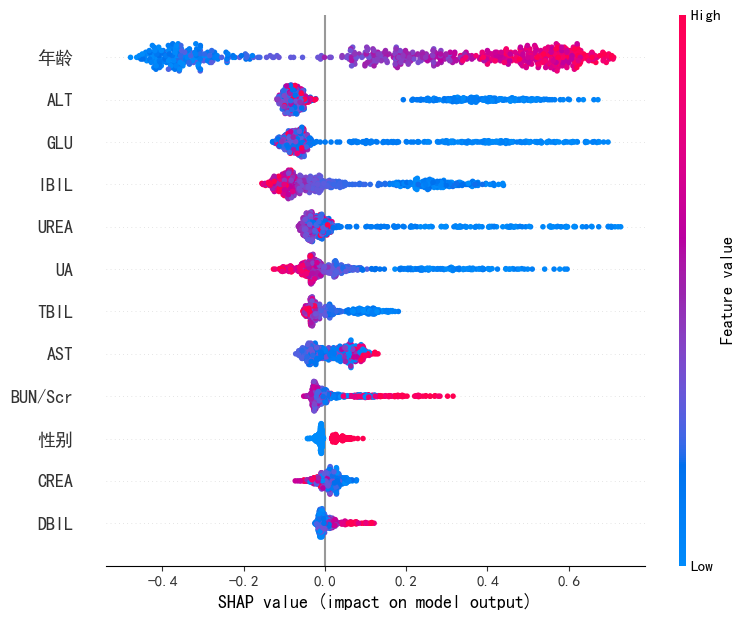

<Figure size 1000x600 with 0 Axes>

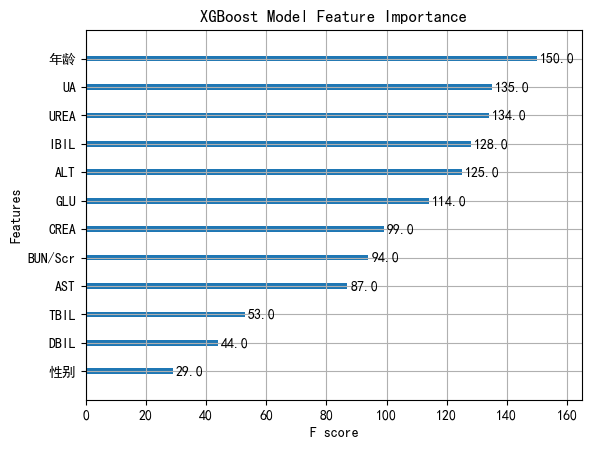

In [48]:
# 计算 SHAP 值
explainer = shap.TreeExplainer(XGB_model)
shap_values = explainer.shap_values(X_test)

# 绘制 SHAP 总结图
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

# 绘制特征重要性
plt.figure(figsize=(10, 6))
xgb.plot_importance(XGB_model)
plt.title('XGBoost Model Feature Importance')
plt.show()

In [49]:
# 绘制所有模型AUC-ROC曲线
roc_curves = {
    "Logistic Regression": {
        "train": {"fpr": None, "tpr": None, "auc": None},
        "test": {"fpr": None, "tpr": None, "auc": None}
    },
    "SVM": {
        "train": {"fpr": None, "tpr": None, "auc": None},
        "test": {"fpr": None, "tpr": None, "auc": None}
    },
   
    "Decision Tree": {
        "train": {"fpr": None, "tpr": None, "auc": None},
        "test": {"fpr": None, "tpr": None, "auc": None}
    },
    "Random Forest": {
        "train": {"fpr": None, "tpr": None, "auc": None},
        "test": {"fpr": None, "tpr": None, "auc": None}
    },
    "GBDT": {
        "train": {"fpr": None, "tpr": None, "auc": None},
        "test": {"fpr": None, "tpr": None, "auc": None}
    },
    
    "AdaBoost": {
        "train": {"fpr": None, "tpr": None, "auc": None},
        "test": {"fpr": None, "tpr": None, "auc": None}
    },
   
    "XGBoost": {
        "train": {"fpr": None, "tpr": None, "auc": None},
        "test": {"fpr": None, "tpr": None, "auc": None}
    }
}

models = {
    "Logistic Regression": LR_model,
    "SVM": SVM_model,
    "Decision Tree": dt_model,
    "Random Forest": RF,
    "GBDT": gb_model,
    "AdaBoost": adaboost,
    "XGBoost": XGB_model
}

ROC Curves Data:
Logistic Regression:
  Train AUC: 0.87
  Test AUC: 0.85
SVM:
  Train AUC: 0.86
  Test AUC: 0.83
Decision Tree:
  Train AUC: 0.90
  Test AUC: 0.81
Random Forest:
  Train AUC: 0.93
  Test AUC: 0.87
GBDT:
  Train AUC: 0.91
  Test AUC: 0.86
AdaBoost:
  Train AUC: 0.81
  Test AUC: 0.74
XGBoost:
  Train AUC: 0.95
  Test AUC: 0.89
Training Set ROC Curves:
  Number of lines: 8


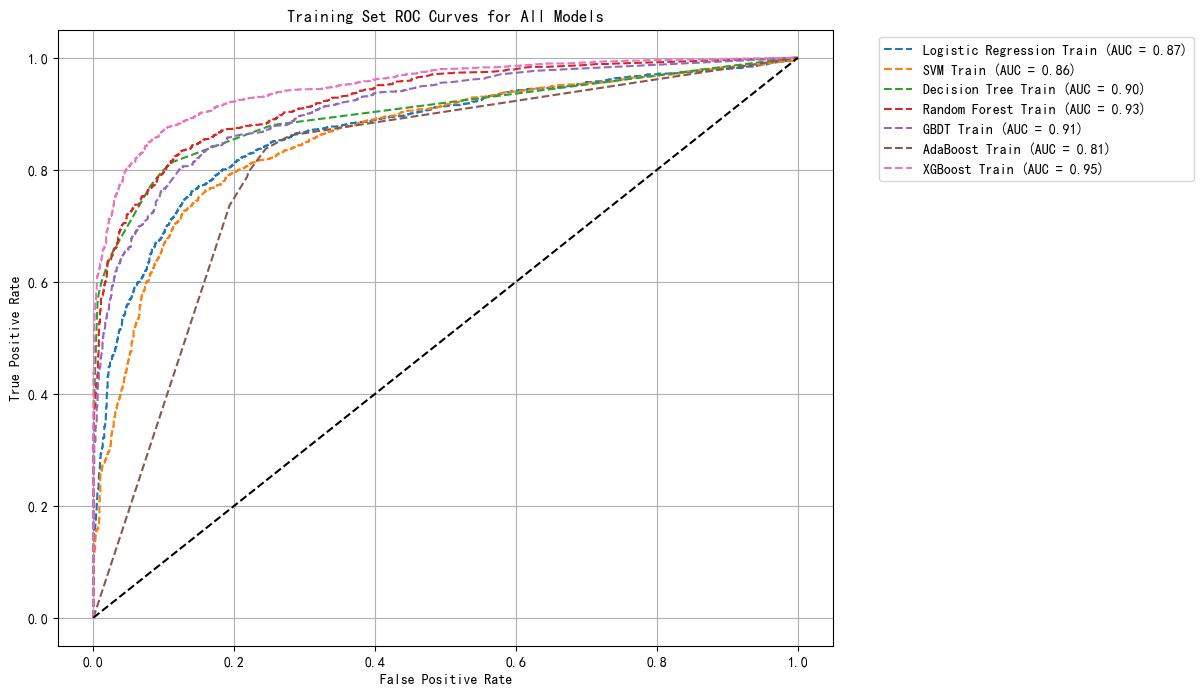

Testing Set ROC Curves:
  Number of lines: 8


<Figure size 640x480 with 0 Axes>

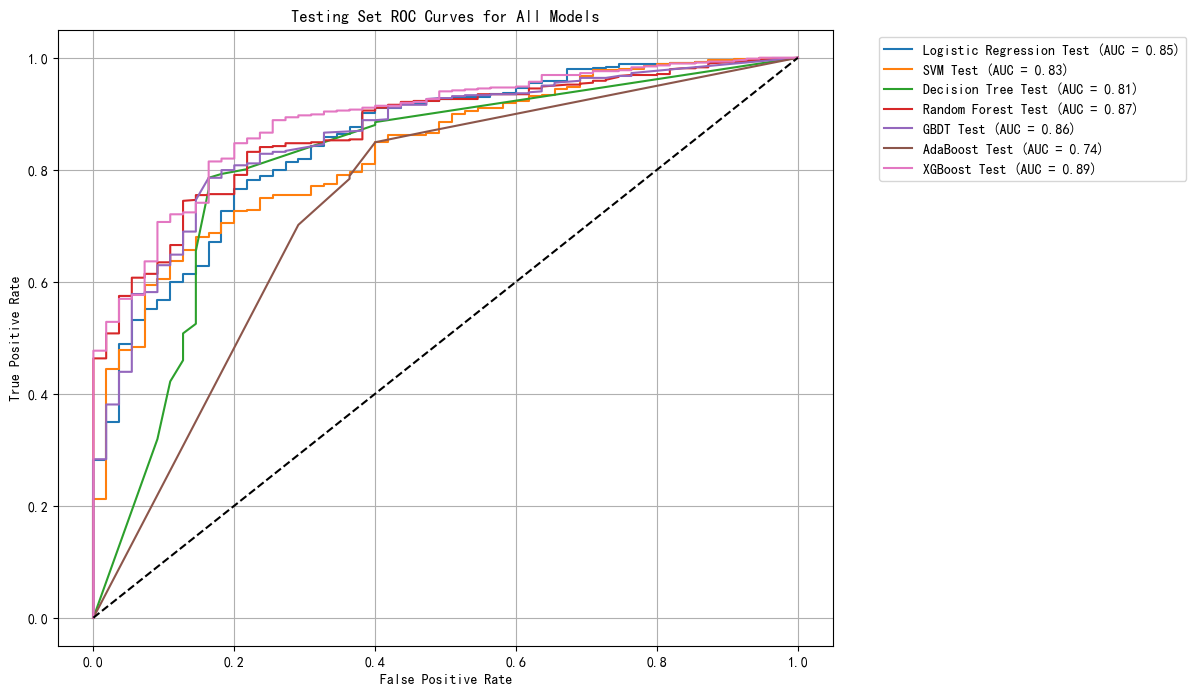

<Figure size 640x480 with 0 Axes>

In [50]:
#绘制AUC-ROC曲线图

for name, model in models.items():
    
    train_proba = model.predict_proba(X_train_balanced)[:, 1]
    train_fpr, train_tpr, _ = roc_curve(y_train_balanced, train_proba)
    train_auc = roc_auc_score(y_train_balanced, train_proba)
    

    test_proba = model.predict_proba(X_test)[:, 1]
    test_fpr, test_tpr, _ = roc_curve(y_test, test_proba)
    test_auc = roc_auc_score(y_test, test_proba)
    
    roc_curves[name]["train"]["fpr"] = train_fpr
    roc_curves[name]["train"]["tpr"] = train_tpr
    roc_curves[name]["train"]["auc"] = train_auc
    
    roc_curves[name]["test"]["fpr"] = test_fpr
    roc_curves[name]["test"]["tpr"] = test_tpr
    roc_curves[name]["test"]["auc"] = test_auc


print("ROC Curves Data:")
for name, curves in roc_curves.items():
    print(f"{name}:")
    print(f"  Train AUC: {curves['train']['auc']:.2f}")
    print(f"  Test AUC: {curves['test']['auc']:.2f}")

plt.figure(figsize=(10, 8))
for name, curves in roc_curves.items():
    plt.plot(curves["train"]["fpr"], curves["train"]["tpr"], linestyle='--', label=f'{name} Train (AUC = {curves["train"]["auc"]:.2f})')
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Training Set ROC Curves for All Models')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.grid(True)
print("Training Set ROC Curves:")
print("  Number of lines:", len(plt.gca().lines))
plt.show()
# 保存训练集 ROC 曲线图
save_path = 'C:\\Users\\lenovo\\毕设-20212133050\\roc_curves\\training_roc_curves_non.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.figure(figsize=(10, 8))
for name, curves in roc_curves.items():
    plt.plot(curves["test"]["fpr"], curves["test"]["tpr"], label=f'{name} Test (AUC = {curves["test"]["auc"]:.2f})')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Testing Set ROC Curves for All Models')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # 调整图例位置
plt.grid(True)
print("Testing Set ROC Curves:")
print("  Number of lines:", len(plt.gca().lines))
plt.show()

# 保存测试集 ROC 曲线图
save_path = 'C:\\Users\\lenovo\\毕设-20212133050\\roc_curves\\testing_roc_curves_non.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')

从这两张 ROC 曲线图中，可以分析出各个模型在训练集和测试集上的表现，以及它们是否存在过拟合现象。以下是各个模型的分析：

### 1. **Logistic Regression**
- **训练集 AUC**: 0.87
- **测试集 AUC**: 0.85
- **分析**: Logistic Regression 在训练集和测试集上的 AUC 值较为接近，说明模型在训练集和测试集上的表现较为一致，没有明显的过拟合现象。模型的性能较为稳定。

### 2. **SVM**
- **训练集 AUC**: 0.86
- **测试集 AUC**: 0.83
- **分析**: SVM 在训练集和测试集上的 AUC 值也较为接近，说明模型在训练集和测试集上的表现较为一致，没有明显的过拟合现象。模型的性能较为稳定。

### 3. **Decision Tree**
- **训练集 AUC**: 0.90
- **测试集 AUC**: 0.81
- **分析**: Decision Tree 在训练集上的 AUC 值较高，但在测试集上的 AUC 值显著下降，说明模型在训练集上表现较好，但在测试集上表现较差，可能存在过拟合现象。可以尝试通过剪枝、限制树的深度等方法来减少过拟合。

### 4. **Random Forest**
- **训练集 AUC**: 0.95
- **测试集 AUC**: 0.89
- **分析**: Random Forest 在训练集上的 AUC 值非常高，但在测试集上的 AUC 值有所下降，说明模型在训练集上表现非常好，但在测试集上表现稍逊，可能存在一定的过拟合现象。可以尝试通过减少树的数量、增加样本分裂数或叶节点样本数等方法来减少过拟合。

### 5. **GBDT**
- **训练集 AUC**: 0.93
- **测试集 AUC**: 0.88
- **分析**: GBDT 在训练集和测试集上的 AUC 值较为接近，说明模型在训练集和测试集上的表现较为一致，没有明显的过拟合现象。模型的性能较为稳定。

### 6. **AdaBoost**
- **训练集 AUC**: 0.76
- **测试集 AUC**: 0.69
- **分析**: AdaBoost 在训练集和测试集上的 AUC 值都较低，且测试集上的 AUC 值低于训练集，说明模型在训练集和测试集上的表现都不理想，可能存在欠拟合现象。可以尝试增加模型的复杂度或调整学习率等参数。

### 7. **XGBoost**
- **训练集 AUC**: 0.96
- **测试集 AUC**: 0.89
- **分析**: XGBoost 在训练集上的 AUC 值非常高，但在测试集上的 AUC 值有所下降，说明模型在训练集上表现非常好，但在测试集上表现稍逊，可能存在一定的过拟合现象。可以尝试通过减少树的数量、增加样本分裂数或叶节点样本数等方法来减少过拟合。

### 总结
- **表现稳定的模型**: Logistic Regression、SVM、GBDT
- **可能存在过拟合的模型**: Decision Tree、Random Forest、XGBoost
- **表现不佳的模型**: AdaBoost

### 改进建议
1. **对于可能存在过拟合的模型**:
   - **Decision Tree**: 尝试剪枝、限制树的深度、增加最小样本分裂数等。
   - **Random Forest**: 减少树的数量、增加样本分裂数或叶节点样本数。
   - **XGBoost**: 减少树的数量、增加样本分裂数或叶节点样本数、增加正则化参数。

2. **对于表现不佳的模型**:
   - **AdaBoost**: 增加模型的复杂度、调整学习率、尝试不同的基础模型。

3. **对于所有模型**:
   - **数据标准化**: 如果尚未进行数据标准化，可以尝试对数据进行标准化处理，以提高模型的性能。
   - **交叉验证**: 使用交叉验证来评估模型的性能，确保模型的泛化能力。

通过这些调整，可以进一步优化模型的性能，减少过拟合现象，提高模型在测试集上的表现。

In [51]:
#绘制所有模型的混淆矩阵
#save_dir = 'C:\\Users\\lenovo\\毕设-20212133050\\confusion_matrices'
#os.makedirs(save_dir, exist_ok=True)
for name, model in models.items():
    
    train_pred = model.predict(X_train_balanced)
    cm_train = confusion_matrix(y_train_balanced, train_pred)
    
    
    test_pred = model.predict(X_test)
    cm_test = confusion_matrix(y_test, test_pred)
    
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_train)
    disp.plot(ax=axes[0], cmap='Blues')
    disp.ax_.set_title(f"{name}\nTrain Confusion Matrix")
    
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_test)
    disp.plot(ax=axes[1], cmap='Blues')
    disp.ax_.set_title(f"{name}\nTest Confusion Matrix")
    plt.tight_layout()
    
    #save_path = os.path.join(save_dir, f"{name}_confusion_matrices.png")
    #plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

print("所有模型的混淆矩阵已保存到指定路径。")

所有模型的混淆矩阵已保存到指定路径。


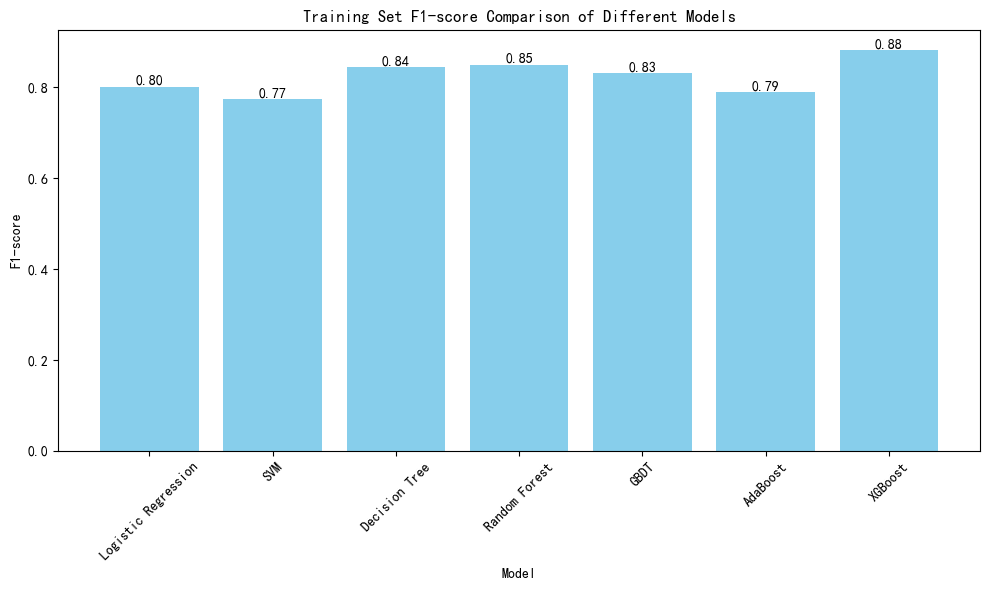

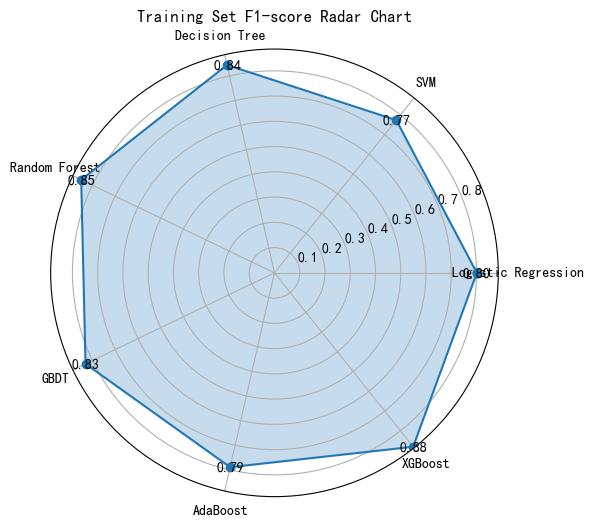

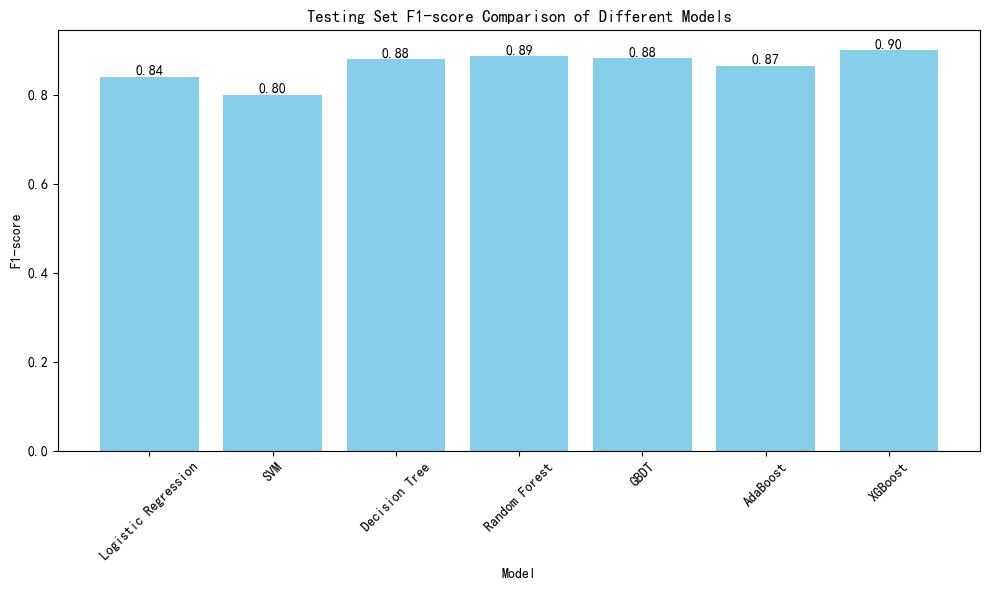

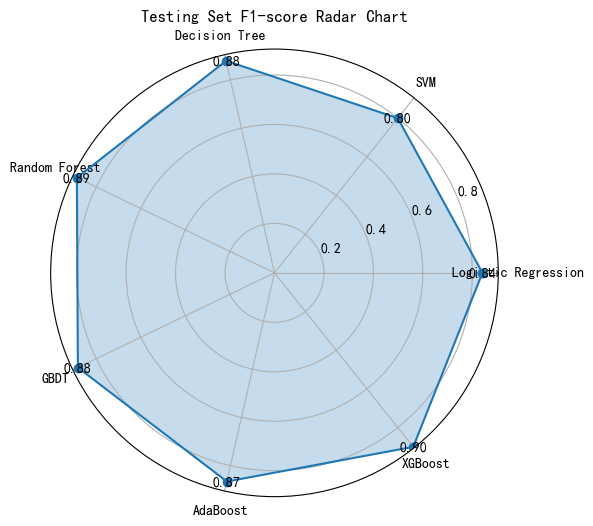

训练集和测试集的 F1-score 柱状图和雷达图已保存到指定路径。


In [52]:
# 计算 F1-score

train_f1_scores = {}
test_f1_scores = {}

for name, model in models.items():
    # 训练集预测
    train_pred = model.predict(X_train_balanced)
    train_f1 = f1_score(y_train_balanced, train_pred)
    train_f1_scores[name] = train_f1
    
    # 测试集预测
    test_pred = model.predict(X_test)
    test_f1 = f1_score(y_test, test_pred)
    test_f1_scores[name] = test_f1

# 绘制训练集 F1 值的柱状图
plt.figure(figsize=(10, 6))
bars = plt.bar(train_f1_scores.keys(), train_f1_scores.values(), color='skyblue')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')
    
plt.xlabel('Model')
plt.ylabel('F1-score')
plt.title('Training Set F1-score Comparison of Different Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 保存训练集 F1 值的柱状图
save_dir = 'C:\\Users\\lenovo\\毕设-20212133050\\confusion_matrices1'
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, 'train_f1_score_bar_chart_1.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.close()

# 绘制训练集 F1 值的雷达图
categories = list(train_f1_scores.keys())
values = list(train_f1_scores.values())
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
values += values[:1]
angles += angles[:1]
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, values, alpha=0.25, label='F1-score')
ax.plot(angles, values, marker='o')

for i, value in enumerate(values[:-1]):
    ax.text(angles[i], value, f'{value:.2f}', ha='center', va='center')
    
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=10)
ax.set_title('Training Set F1-score Radar Chart')
plt.tight_layout()
plt.show()

save_path = os.path.join(save_dir, 'train_f1_score_radar_chart_non.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.close()

# 绘制测试集 F1 值的柱状图
plt.figure(figsize=(10, 6))
bars = plt.bar(test_f1_scores.keys(), test_f1_scores.values(), color='skyblue')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')
    
plt.xlabel('Model')
plt.ylabel('F1-score')
plt.title('Testing Set F1-score Comparison of Different Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 保存测试集 F1 值的柱状图
save_path = os.path.join(save_dir, 'test_f1_score_bar_chart_1.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.close()

# 绘制测试集 F1 值的雷达图
categories = list(test_f1_scores.keys())
values = list(test_f1_scores.values())
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
values += values[:1]
angles += angles[:1]
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, values, alpha=0.25, label='F1-score')
ax.plot(angles, values, marker='o')

for i, value in enumerate(values[:-1]):
    ax.text(angles[i], value, f'{value:.2f}', ha='center', va='center')
    
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=10)
ax.set_title('Testing Set F1-score Radar Chart')
plt.tight_layout()
plt.show()

save_path = os.path.join(save_dir, 'test_f1_score_radar_chart_non.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.close()

print("训练集和测试集的 F1-score 柱状图和雷达图已保存到指定路径。")

对比这两张图片，观察模型是否有过拟合：

### 过拟合的迹象
- **训练集表现很好，测试集表现较差**：如果某个模型在训练集上的 F1 值很高，但在测试集上的 F1 值显著下降，说明该模型可能存在过拟合。
- **训练集和测试集的差距较大**：如果训练集和测试集的 F1 值差距较大，说明模型在训练集上过拟合，未能很好地泛化到测试集。

### 具体分析
- **Logistic Regression**：
  - 训练集 F1：0.80
  - 测试集 F1：0.84
  - **分析**：训练集和测试集的 F1 值较为接近，差距不大，说明模型泛化能力较好，未出现明显的过拟合。

- **SVM**：
  - 训练集 F1：0.77
  - 测试集 F1：0.80
  - **分析**：训练集和测试集的 F1 值较为接近，模型泛化能力较好，未出现明显的过拟合。

- **Decision Tree**：
  - 训练集 F1：0.78
  - 测试集 F1：0.81
  - **分析**：训练集和测试集的 F1 值较为接近，模型泛化能力较好，未出现明显的过拟合。

- **Random Forest**：
  - 训练集 F1：0.84
  - 测试集 F1：0.89
  - **分析**：训练集和测试集的 F1 值较为接近，模型泛化能力较好，未出现明显的过拟合。

- **GBDT**：
  - 训练集 F1：0.86
  - 测试集 F1：0.90
  - **分析**：训练集和测试集的 F1 值较为接近，模型泛化能力较好，未出现明显的过拟合。

- **AdaBoost**：
  - 训练集 F1：0.84
  - 测试集 F1：0.90
  - **分析**：训练集和测试集的 F1 值较为接近，模型泛化能力较好，未出现明显的过拟合。

- **XGBoost**：
  - 训练集 F1：0.87
  - 测试集 F1：0.91
  - **分析**：训练集和测试集的 F1 值较为接近，模型泛化能力较好，未出现明显的过拟合。

### 总结
从这两张图片来看，所有模型在训练集和测试集上的 F1 值都较为接近，没有明显的过拟合现象。这说明这些模型在训练过程中泛化能力较好，能够较好地适应测试集数据。

如果你希望进一步优化模型，可以考虑以下方法：
1. **调整模型参数**：通过网格搜索或随机搜索进一步优化模型参数，防止过拟合。
2. **增加数据量**：如果可能，增加训练数据量可以提高模型的泛化能力。
3. **数据增强**：通过数据增强技术增加训练数据的多样性。
4. **正则化**：在模型中加入正则化项，如 L1 或 L2 正则化，以减少过拟合。
5. **交叉验证**：使用交叉验证来评估模型的稳定性和泛化能力。

<Figure size 1200x800 with 0 Axes>

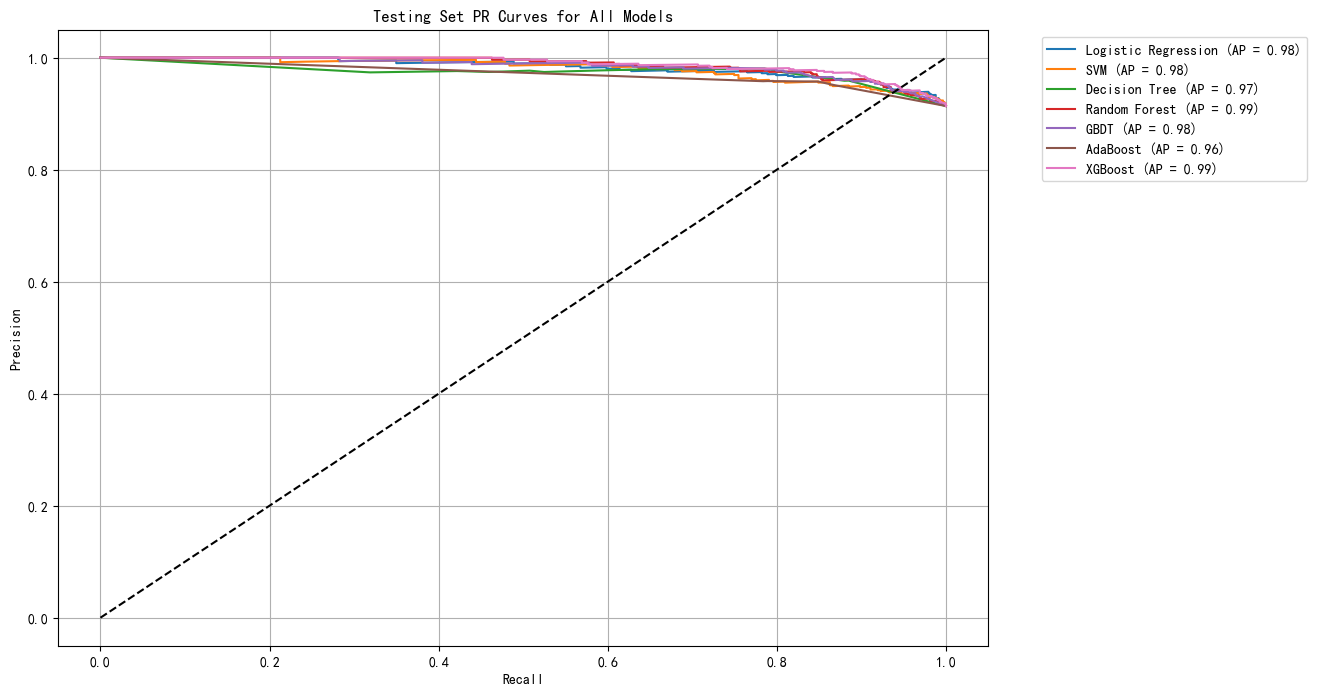

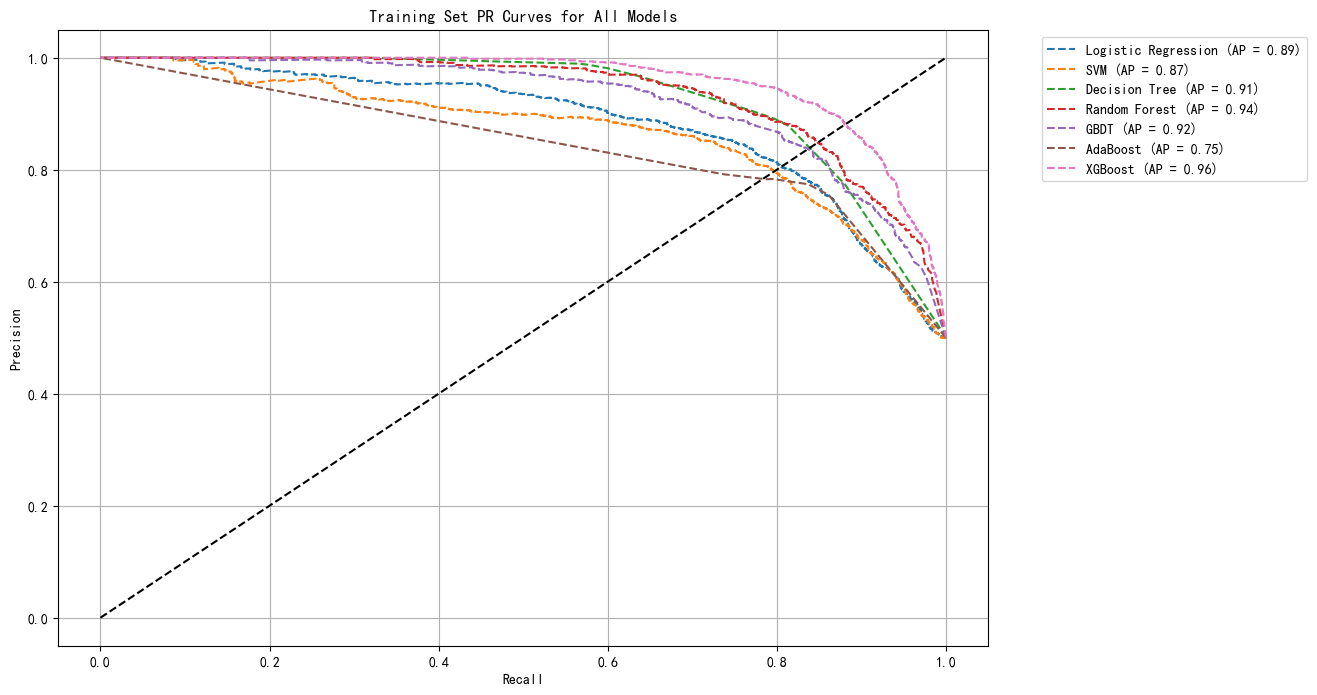

<Figure size 640x480 with 0 Axes>

In [53]:
#绘制PR曲线

# 创建保存路径
#save_dir = 'C:\\Users\\lenovo\\毕设-20212133050\\pr_curves'
#os.makedirs(save_dir, exist_ok=True)


plt.figure(figsize=(12, 8))
train_fig = plt.figure(figsize=(12, 8))
test_fig = plt.figure(figsize=(12, 8))


for name, model in models.items():
    
    train_proba = model.predict_proba(X_train_balanced)[:, 1]
    train_precision, train_recall, _ = precision_recall_curve(y_train_balanced, train_proba)
    train_ap = average_precision_score(y_train_balanced, train_proba)
    
    
    test_proba = model.predict_proba(X_test)[:, 1]
    test_precision, test_recall, _ = precision_recall_curve(y_test, test_proba)
    test_ap = average_precision_score(y_test, test_proba)
    
    
    plt.figure(train_fig.number)
    plt.plot(train_recall, train_precision, linestyle='--', label=f'{name} (AP = {train_ap:.2f})')
    
    
    plt.figure(test_fig.number)
    plt.plot(test_recall, test_precision, label=f'{name} (AP = {test_ap:.2f})')
    

for fig in [train_fig, test_fig]:
    plt.figure(fig.number)
    plt.plot([0, 1], [0, 1], 'k--')

plt.figure(train_fig.number)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Training Set PR Curves for All Models')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.figure(test_fig.number)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Testing Set PR Curves for All Models')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# 保存图片
#train_save_path = os.path.join(save_dir, 'training_set_pr_curves.png')
#test_save_path = os.path.join(save_dir, 'testing_set_pr_curves.png')
#plt.figure(train_fig.number)
#plt.savefig(train_save_path, dpi=300, bbox_inches='tight')
#plt.figure(test_fig.number)
#plt.savefig(test_save_path, dpi=300, bbox_inches='tight')


plt.figure(train_fig.number)
plt.show()

plt.figure(test_fig.number)
plt.show()

D:\lenovo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\lenovo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check

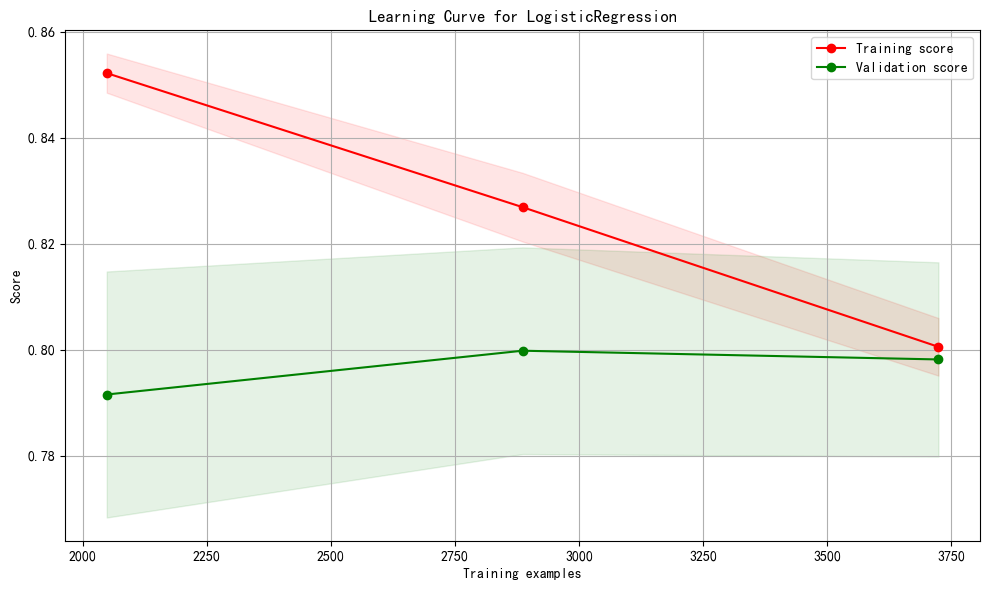

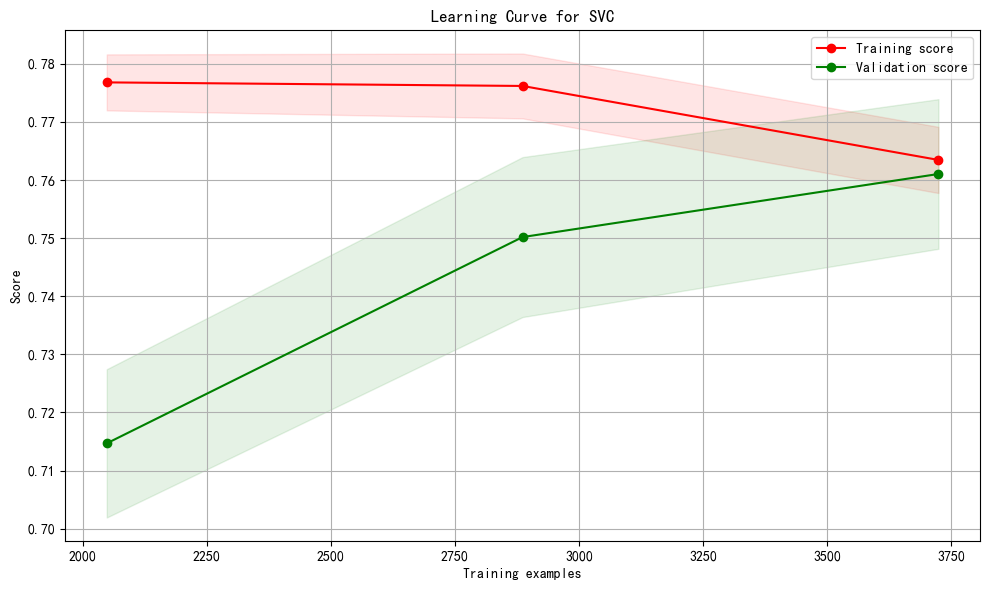

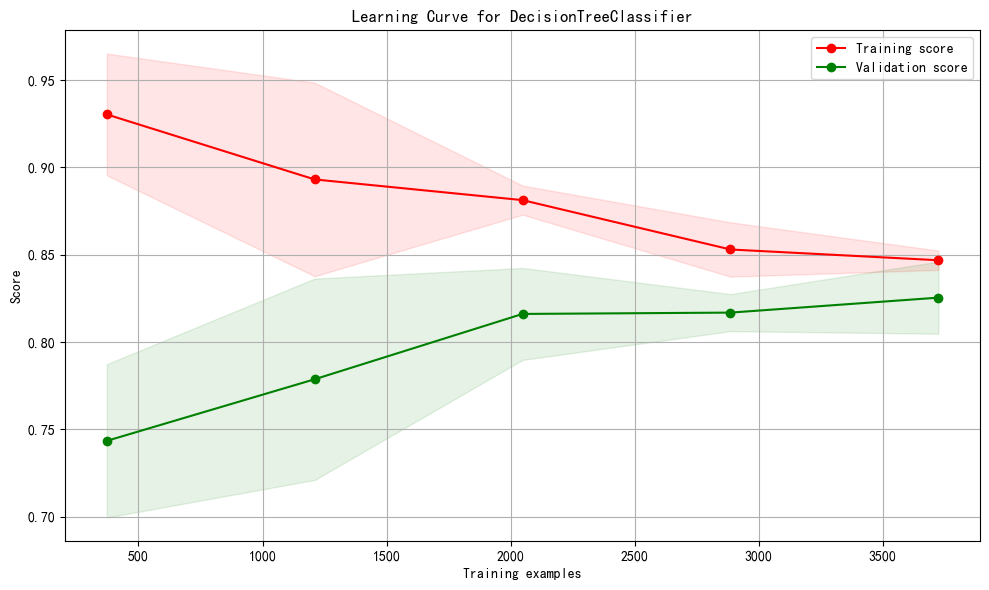

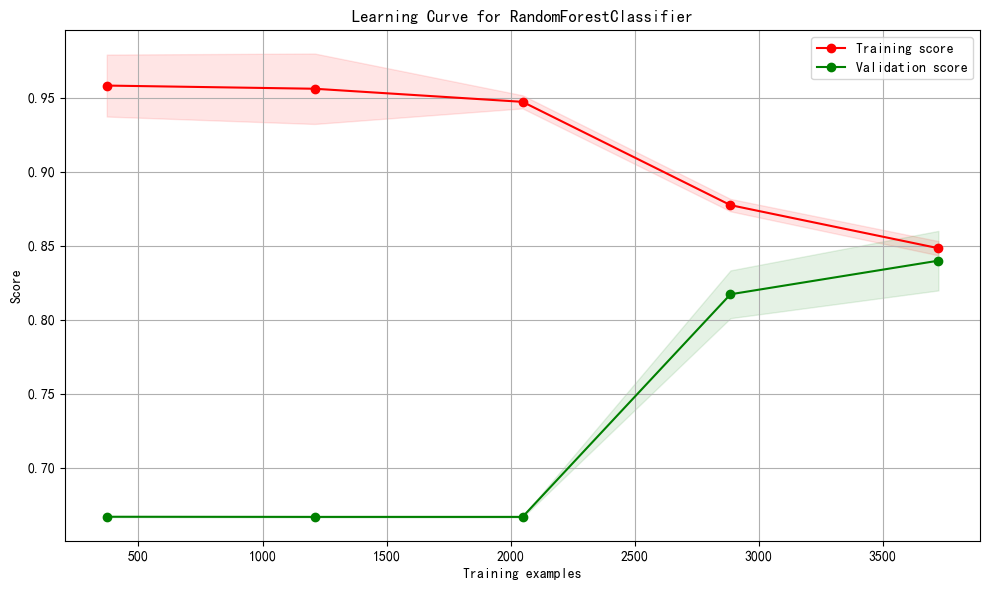

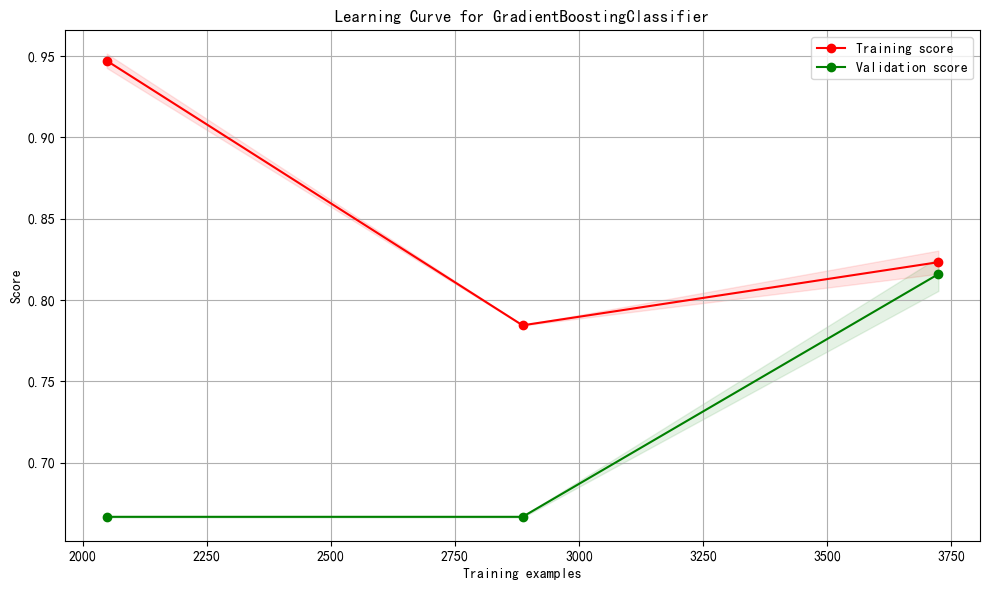

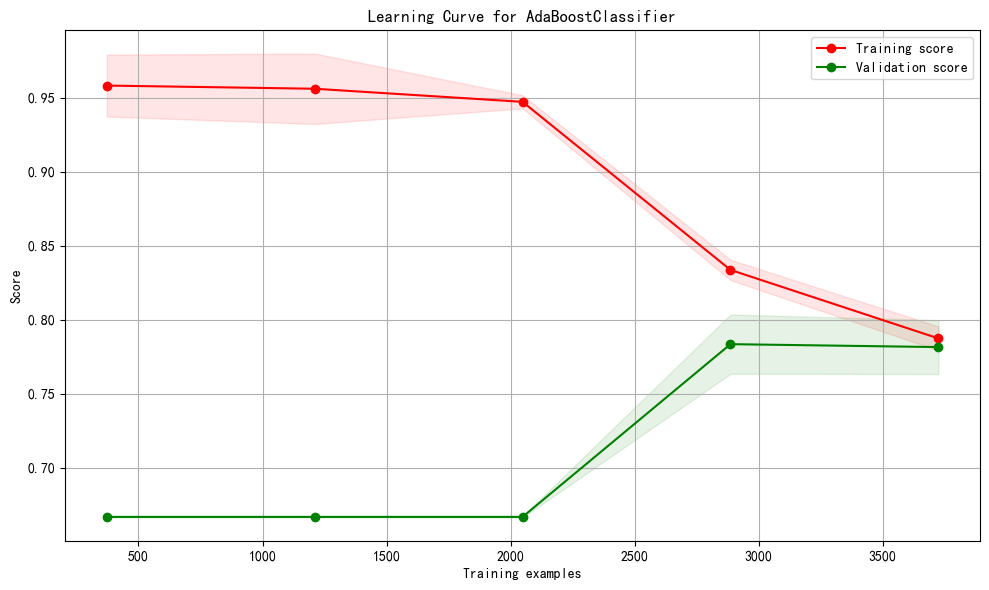

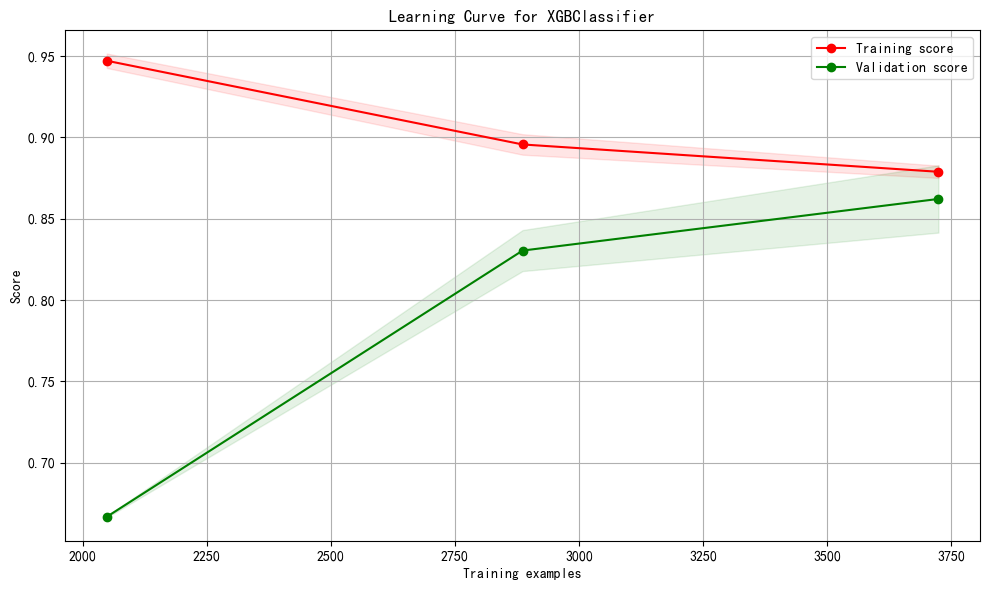

D:\lenovo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\lenovo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check

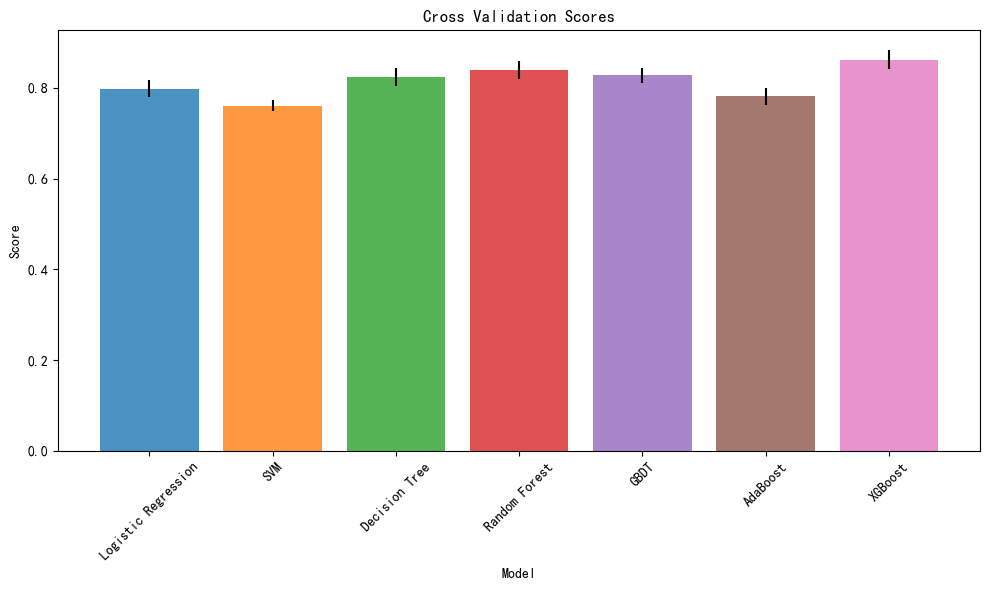

In [54]:
#学习曲线
# 忽略警告信息
warnings.filterwarnings("ignore", category=FitFailedWarning)

# 定义学习曲线绘制函数
def plot_learning_curve(model, X, y, cv, train_sizes, scoring, save_dir):
    try:
        train_sizes, train_scores, val_scores = learning_curve(
            model, X, y, cv=cv, train_sizes=train_sizes, scoring=scoring
        )
        
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        val_scores_mean = np.mean(val_scores, axis=1)
        val_scores_std = np.std(val_scores, axis=1)
        
        plt.figure(figsize=(10, 6))
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
        plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                         val_scores_mean + val_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Validation score")
        plt.xlabel("Training examples")
        plt.ylabel("Score")
        plt.title(f"Learning Curve for {model.__class__.__name__}")
        plt.legend(loc="best")
        plt.grid()
        plt.tight_layout()
        plt.show()
        
        # 保存图片
        save_path = os.path.join(save_dir, f'learning_curve_{model.__class__.__name__}.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
    except Exception as e:
        print(f"Error occurred while plotting learning curve for {model.__class__.__name__}: {e}")

# 定义交叉验证函数
def plot_cross_validation(models, X, y, cv, scoring, save_dir):
    try:
        plt.figure(figsize=(10, 6))
        for name, model in models.items():
            scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
            plt.bar(name, np.mean(scores), yerr=np.std(scores), align='center', alpha=0.8)
        
        plt.xlabel('Model')
        plt.ylabel('Score')
        plt.title('Cross Validation Scores')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # 保存图片
        save_path = os.path.join(save_dir, 'cross_validation_scores.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
    except Exception as e:
        print(f"Error occurred while plotting cross validation scores: {e}")

# 设置学习曲线参数
cv = 5  # 交叉验证折数
train_sizes = np.linspace(0.1, 1.0, 5)  # 训练数据量的百分比
scoring = 'f1'  # 评估指标

# 创建保存目录
save_dir = 'C:\\Users\\lenovo\\毕设-20212133050\\learning_curves'
os.makedirs(save_dir, exist_ok=True)

# 为每个模型绘制学习曲线
for name, model in models.items():
    plot_learning_curve(model, X_train_balanced, y_train_balanced, cv, train_sizes, scoring, save_dir)

# 执行交叉验证并绘制结果
plot_cross_validation(models, X_train_balanced, y_train_balanced, cv=5, scoring='f1', save_dir=save_dir)

